# عمر شعبان يوسف حرب 
## 120222897
### مشروع مادة تنقيب البيانات (عملي )

In [1]:
!pip install selenium

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install lxml

Defaulting to user installation because normal site-packages is not writeable


# web Scraping

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import re

# إعداد متصفح كروم بدون واجهة + User Agent
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')
options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/137.0.0.0 Safari/537.36")

# مسار chromedriver (عدّل المسار حسب جهازك)
service = Service("C://Users/jamal2000/Desktop/chromedriver-win64/chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)

# فتح الموقع
url = "https://www.emiratesauction.com/ar/motors"
driver.get(url)

# انتظر تحميل البطاقات
WebDriverWait(driver, 15).until(
    EC.presence_of_element_located((By.CLASS_NAME, "list-card-container"))
)

# قراءة الصفحة بعد التحميل
html = driver.page_source
soup = BeautifulSoup(html, "html.parser")
driver.quit()

# استخراج البطاقات
cards = soup.find_all("div", class_="list-card-container")
print(f"تم العثور على {len(cards)} بطاقة سيارة")

data = []

for card in cards:
    try:
        # العنوان
        title_tag = card.find("h2", id=re.compile(r"^title_"))
        title = title_tag.get_text(strip=True) if title_tag else ""

        # النص الكامل
        full_text = card.get_text(separator=" ", strip=True)

        # رقم التسلسل
        seq_match = re.search(r"التسلسل\s*(\d+)", full_text)
        seq = seq_match.group(1) if seq_match else ""

        # الوقت المتبقي (استخراج من div يحتوي "الوقت المتبقي")
        time_left = ""
        for div in card.find_all("div"):
            if "الوقت المتبقي" in div.get_text():
                time_text = div.get_text(strip=True)
                time_match = re.search(r"الوقت المتبقي\s*:\s*(.*)", time_text)
                if time_match:
                    time_left = time_match.group(1).strip()
                break

        # عدد المزايدات
        bids_match = re.search(r"مزايدات\s*:\s*(\d+)", full_text)
        bids = bids_match.group(1) if bids_match else "0"

        # السعر
        price = ""
        price_div = card.find("div", id=f"CARD_PRICE_{seq}")
        if price_div:
            price_spans = price_div.find_all("span")
            for span in price_spans:
                classes = span.get("class", [])
                if 'text-decoration-line-through' not in classes:
                    price = span.get_text(strip=True)
                    price = price.replace(",", "").replace("٬", "").replace("ر.س", "").strip()
                    if price and re.match(r"^\d+$", price):
                        break
            if not price:
                fm = price_div.find("div", class_="font-medium")
                if fm:
                    price = fm.get_text(strip=True).replace(",", "").replace("٬", "").replace("ر.س", "").strip()

        # إضافة إلى القائمة
        data.append({
            "title": title,
            "sequence": seq,
            "time_left": time_left,
            "bids": bids,
            "price": price
        })

    except Exception as e:
        print(f"خطأ في استخراج بيانات سيارة: {e}")

# حفظ إلى CSV
df = pd.DataFrame(data)
print(df.head())  # طباعة أول 5 نتائج للتأكد

df.to_csv("emirates_auction_data.csv", index=False, encoding="utf-8-sig", sep=';')
print(f"تم حفظ {len(data)} سيارة في emirates_auction_data.csv")


تم العثور على 100 بطاقة سيارة
                      title sequence time_left bids  price
0      فولكس واجن جولف 2015   564360     13د :   16   1700
1        تويوتا افالون 2013   564369     13د :  105  10500
2      فولكس واجن جيتا 2014   568112     13د :   37   4100
3           نيسان تيدا 2008   565754     13د :   17   2100
4  فيكتوري SCH5022XXYD 2022   568115     13د :   49   5000
تم حفظ 100 سيارة في emirates_auction_data.csv


# الخطوة 1: تحميل وتنظيف البيانات



In [2]:
# تحميل البيانات من CSV
df = pd.read_csv("emirates_auction_data.csv", sep=';', encoding='utf-8-sig')
print("عدد الصفوف الأصلية:", len(df))
print(df.head())

عدد الصفوف الأصلية: 100
                      title  sequence time_left  bids  price
0      فولكس واجن جولف 2015    564360     13د :    16   1700
1        تويوتا افالون 2013    564369     13د :   105  10500
2      فولكس واجن جيتا 2014    568112     13د :    37   4100
3           نيسان تيدا 2008    565754     13د :    17   2100
4  فيكتوري SCH5022XXYD 2022    568115     13د :    49   5000


# الخطوة 2: معالجة القيم المفقودة

In [3]:
# تحويل الأعمدة الرقمية
df['bids'] = pd.to_numeric(df['bids'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

# حذف الصفوف التي تحتوي على price أو bids مفقودة
df = df.dropna(subset=['price', 'bids'])

print("عدد الصفوف بعد حذف المفقود:", len(df))

عدد الصفوف بعد حذف المفقود: 100


# الخطوة 3: تحويل الخصائص النصية إلى أرقام (Encoding)
سنأخذ فقط بعض الخصائص من title مثل: نوع السيارة أو سنة الصنع إن وُجدت

In [4]:
# استخراج نوع السيارة من العنوان
df['car_brand'] = df['title'].str.extract(r'^(\S+)')

# تحويل car_brand إلى رقم باستخدام encoding
df['car_brand'] = df['car_brand'].astype('category').cat.codes

# الخطوة 4: تقييس البيانات (Scaling)

In [5]:
from sklearn.preprocessing import StandardScaler

# اختيار الخصائص الرقمية
features = ['bids', 'price', 'car_brand']
X = df[features]

# تطبيق التقييس
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# الخطوة 5: التعامل مع القيم الشاذة (Outliers)

In [6]:
from scipy import stats
import numpy as np

# إزالة القيم الشاذة باستخدام Z-score
z_scores = np.abs(stats.zscore(X_scaled))
df_clean = df[(z_scores < 3).all(axis=1)]
X_clean = scaler.fit_transform(df_clean[features])
print("عدد الصفوف بعد إزالة القيم الشاذة:", len(df_clean))

عدد الصفوف بعد إزالة القيم الشاذة: 98


# الخطوة 6: تدريب النماذج (Random Forest, SVM, Logistic)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# تحديد المتغير الهدف (نصنف السيارات إلى سعر مرتفع ومنخفض مثلاً)
df_clean['price_class'] = (df_clean['price'] > df_clean['price'].median()).astype(int)

X = X_clean
y = df_clean['price_class']

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n🔹 {name} 🔹\n", classification_report(y_test, preds))


🔹 Random Forest 🔹
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00         9

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20


🔹 Logistic Regression 🔹
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20


🔹 SVM 🔹
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg      

C:\Users\jamal2000\AppData\Local\Temp\ipykernel_7148\2748824052.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['price_class'] = (df_clean['price'] > df_clean['price'].median()).astype(int)


# الخطوة 7: اختيار الميزات باستخدام Correlation Matrix

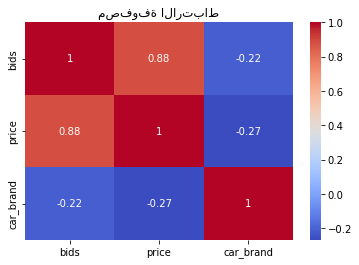

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# رسم مصفوفة الارتباط
corr_matrix = df_clean[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("مصفوفة الارتباط")
plt.show()

# حذف الميزات المرتبطة بشدة (مثلاً price و bids)
reduced_features = ['bids', 'car_brand']  # نفترض أن price و bids كانت مرتبطة بشدة
X_reduced = scaler.fit_transform(df_clean[reduced_features])

# الخطوة 8: تقليل الأبعاد باستخدام PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # نحتفظ بـ 95% من التباين
X_pca = pca.fit_transform(X)

print("عدد المكونات بعد PCA:", X_pca.shape[1])

عدد المكونات بعد PCA: 2


# الخطوة 9: مقارنة الأداء
## أ) البيانات الأصلية:

In [10]:
# التدريب باستخدام X (البيانات الأصلية المقيّسة)
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n {name} - Original Features \n", classification_report(y_test, preds))


 Random Forest - Original Features 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20


 Logistic Regression - Original Features 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20


 SVM - Original Features 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg      

## ب) البيانات بعد Correlation Matrix:

In [11]:
# تقسيم البيانات بعد حذف الميزات المرتبطة
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(Xr_train, yr_train)
    preds = model.predict(Xr_test)
    print(f"\n {name} - After Correlation Filtering \n", classification_report(yr_test, preds))


 Random Forest - After Correlation Filtering 
               precision    recall  f1-score   support

           0       0.79      1.00      0.88        11
           1       1.00      0.67      0.80         9

    accuracy                           0.85        20
   macro avg       0.89      0.83      0.84        20
weighted avg       0.88      0.85      0.84        20


 Logistic Regression - After Correlation Filtering 
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.86      0.67      0.75         9

    accuracy                           0.80        20
   macro avg       0.81      0.79      0.79        20
weighted avg       0.81      0.80      0.80        20


 SVM - After Correlation Filtering 
               precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.86      0.67      0.75         9

    accuracy                           0.8

## ج) البيانات بعد PCA:

In [13]:
Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

for name, model in models.items():
    model.fit(Xp_train, yp_train)
    preds = model.predict(Xp_test)
    print(f"\n {name} - After PCA \n", classification_report(yp_test, preds))


 Random Forest - After PCA 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20


 Logistic Regression - After PCA 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.95        20
weighted avg       0.95      0.95      0.95        20


 SVM - After PCA 
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        11
           1       1.00      0.89      0.94         9

    accuracy                           0.95        20
   macro avg       0.96      0.94      0.9

# end